In [1]:
import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
    SpatialPadd,
    SpatialCropd,
    ScaleIntensityd,
    ShiftIntensityd,
    ResizeD
)
from monai.utils import set_determinism

import torch

print_config()

MONAI version: 1.1.0
Numpy version: 1.23.5
Pytorch version: 2.0.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /usr/local/lib/python3.8/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.12
Nibabel version: 5.1.0
scikit-image version: 0.20.0
Pillow version: 9.5.0
Tensorboard version: 2.12.3
gdown version: 4.7.1
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.65.0
lmdb version: 1.4.1
psutil version: 5.9.5
pandas version: 2.0.1
einops version: 0.6.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 2.3.2
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
data_dir =  "/home/Task07_Pancreas/"
images_dir = os.path.join(data_dir, "imagesTr")
labels_dir = os.path.join(data_dir, "labelsTr")

In [3]:

image_paths = [os.path.join(images_dir, file) for file in os.listdir(images_dir) if not file.endswith('.DS_Store')]

label_paths = [os.path.join(labels_dir, file) for file in os.listdir(labels_dir) if not file.endswith('.DS_Store')]


In [13]:
class ConvertToMultiChannelPancreasClass(MapTransform):
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            label = d[key].squeeze(0)  
            stacked_label = torch.stack([label == 1, label == 2], dim=0)
            d[key] = stacked_label.float()
        return d


In [14]:
train_transform = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    EnsureTyped(keys=["image", "label"]),
    ConvertToMultiChannelPancreasClass(keys=["label"]),  # Convert label to multiple channels
    NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),  # Normalize image intensities
    ResizeD(keys=["image", "label"], spatial_size=[224, 224, 144], mode=("trilinear", "nearest")),  # Resize image and label
])

val_transform = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    EnsureTyped(keys=["image", "label"]),
    ConvertToMultiChannelPancreasClass(keys=["label"]),  # Convert label to multiple channels
    NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),  # Normalize image intensities
    ResizeD(keys=["image", "label"], spatial_size=[224, 224, 144], mode=("trilinear", "nearest")),  # Resize image and label
])


In [15]:
root_dir =  "/home/"
# here we don't cache any data in case out of memory issue
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task07_Pancreas",
    transform=train_transform,
    section="training",
    download=False,
    cache_rate=0.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task07_Pancreas",
    transform=val_transform,
    section="validation",
    download=False,
    cache_rate=0.0,
    num_workers=4,
)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4)

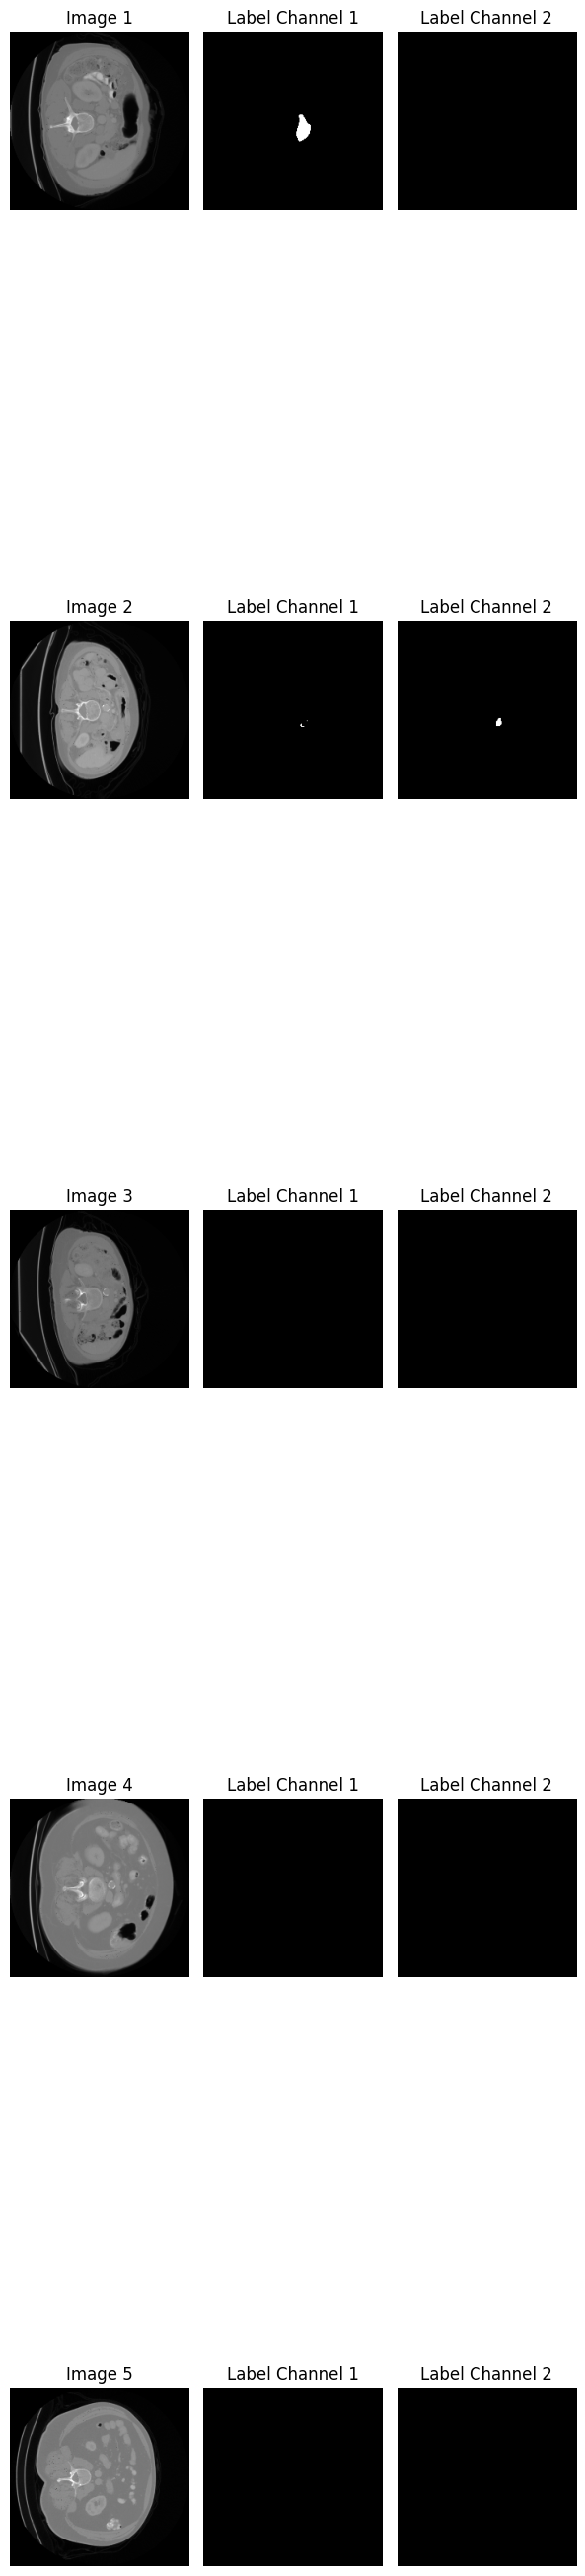

In [16]:
import matplotlib.pyplot as plt

num_images = 5
image_size = (64, 64)  # Adjust the desired image size

plt.figure(figsize=(8, 6*num_images))
for i in range(num_images):
    val_data_example = train_ds[i]
    plt.subplot(num_images, 4, 4*i + 1)
    plt.title(f"Image {i+1}")
    plt.imshow(val_data_example["image"][0, :, :, 30].detach().cpu(), cmap="gray")
    plt.axis("off")

    for j in range(val_data_example['label'].shape[0]):
        plt.subplot(num_images, 4, 4*i + 2 + j)
        plt.title(f"Label Channel {j+1}")
        plt.imshow(val_data_example["label"][j, :, :, 30].detach().cpu(), cmap="gray")
        plt.axis("off")

plt.tight_layout()
plt.show()


In [17]:
max_epochs = 30
val_interval = 1
VAL_AMP = True

# standard PyTorch program style: create SegResNet, DiceLoss, and Adam optimizer
device = torch.device("cuda:0")
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=1,  # change from 4 to 1
    out_channels=2,  # change from 1 to 2
    dropout_prob=0.2,
).to(device)

loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])


# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True


In [18]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        print(f'Input size: {inputs.size()}, label size: {labels.size()}')
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            dice_metric.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start


----------
epoch 1/30


/usr/local/lib/python3.8/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/monai/data/__init__.py:120: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  t = cls([], dtype=storage.dtype, device=storage.device)


Input size: torch.Size([1, 1, 224, 224, 144]), label size: torch.Size([1, 2, 224, 224, 144])


/usr/local/lib/python3.8/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages di

1/225, train_loss: 0.9947, step time: 2.4625
Input size: torch.Size([1, 1, 224, 224, 144]), label size: torch.Size([1, 2, 224, 224, 144])
2/225, train_loss: 0.9933, step time: 0.3511
Input size: torch.Size([1, 1, 224, 224, 144]), label size: torch.Size([1, 2, 224, 224, 144])
3/225, train_loss: 0.9935, step time: 0.3406
Input size: torch.Size([1, 1, 224, 224, 144]), label size: torch.Size([1, 2, 224, 224, 144])
4/225, train_loss: 0.9953, step time: 0.3380
Input size: torch.Size([1, 1, 224, 224, 144]), label size: torch.Size([1, 2, 224, 224, 144])
5/225, train_loss: 0.9946, step time: 0.4044
Input size: torch.Size([1, 1, 224, 224, 144]), label size: torch.Size([1, 2, 224, 224, 144])
6/225, train_loss: 0.9886, step time: 0.3356
Input size: torch.Size([1, 1, 224, 224, 144]), label size: torch.Size([1, 2, 224, 224, 144])
7/225, train_loss: 0.9922, step time: 0.3375
Input size: torch.Size([1, 1, 224, 224, 144]), label size: torch.Size([1, 2, 224, 224, 144])
8/225, train_loss: 0.9970, step ti

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, max_epochs + 1)

plt.plot(epochs, metric_values, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Mean Dice Score')
plt.title('Epochs vs Mean Dice Score')
plt.grid(True)
plt.show()
